# Time comparison

In this note, we use several algorithms and packages and compare computation time of them.

## Introduction

We call
$$ \textrm{minimize}\quad f(x) = - \sum_{i=1}^n \log \sum_{j=1}^k x_j L_{ij} $$
$$ \textrm{subject to}\quad x \succeq 0,\quad \sum_{j=1}^m x_j = 0 $$
the primal problem (P).

The KW dual problem of (P) is
$$ \textrm{minimize}\quad f(x) = - \sum_{i=1}^n \log y_i $$
$$ \textrm{subject to}\quad y \succeq 0,\quad L^T y \preceq n $$
and is denoted by (D).

In [1]:
# Call some package
using Ipopt, JuMP, PyPlot, RCall

# Set a working directory

cd("$(homedir())/Desktop/gaussmix")

The following is to import $L$ from R code.

In [2]:
# input
# n : number of observations, g : grid mult

# output
# L : matrix of likelihood, m : grid size, x : solution, t : computation time
function get_L(n,m)
    @rput n m;
    reval("source('./comptime.R')");
    L = @rget L;
    x = @rget x_fitted;
    t = @rget t_fitted;
    return L, x, t
end

get_L (generic function with 1 method)

The following codes are for primal and dual vanilla IPOPT.

In [3]:
# vanilla primal ipopt

function vanilla_ipopt(L)
    n = size(L,1); k = size(L,2);
    m = Model(solver=IpoptSolver(print_level=0));
    @variable(m, x[1:k], start = 1/k);
    @NLobjective(m, Min, -sum(log(sum(L[i,j]*x[j] for j=1:k)) for i=1:n));
    @constraint(m, sum(x) == 1);
    @constraint(m, x.>= 0);
    solve(m);
    return getvalue(x)
end

# vanilla dual ipopt

function vanilla_dual(L)
    n = size(L,1)
    m = Model(solver=IpoptSolver(print_level=0));
    @variable(m, y[1:n] >= 0);
    @NLobjective(m, Min, -sum(log(y[i]) for i=1:n));
    @constraint(m, cons, n .>= L'*y);
    solve(m);
    x = getdual(cons);
    x = x/sum(x);
end

vanilla_dual (generic function with 1 method)

Between line search and trust region we found that Wolfe's condition always holds and the trust region step is always accepted. Therefore, we can avoid backtracking or actual reduction checking. 

In [4]:
# line search sequential quadratic programming for primal

function ls_sqp(L)
    n = size(L,1); k = size(L,2);
    iter = 20;
    tol = 1e-2;
    x = ones(k)/k;
    for i = 1:iter
        # gradient and Hessian computation
        Z = Diagonal(1./(L*x)) * L;
        g = -Z'*ones(n);
        H = Z'*Z;
        
        # define a subproblem
        m = Model(solver=IpoptSolver(print_level = 0));
        @variable(m, p[1:k]);
        @objective(m, Min, sum(0.5*p[i]*H[i,j]*p[j] for i = 1:k, j = 1:k )+sum(g[i]*p[i] for i = 1:k));
        @constraint(m, ec, sum(p[i] for i = 1:k) == 0); ## p is only in the simplex
        @constraint(m, ic, p+x .>= 0);                                    
        solve(m);
                                        
        # convergence check - By KKT
        if norm(g - getdual(ic) - getdual(ec),Inf) < tol
            break;
        end
                                        
        # otherwise do update               
        x = abs(getvalue(p)+x); # make sure x is positive
        x = x/sum(x) # renormalize           
    end
    return x
end
              

# line search dual SQP

function dual_sqp(L)
    n = size(L,1); k = size(L,2);
    iter = 20;
    tol = 1e-2;
    y = ones(n);
    for i = 1:iter
        # gradient and Hessian computation
        g = -1./y;
        h = 1./(y.^2);
        
        # define a subproblem
        m = Model(solver=IpoptSolver(print_level = 0));
        @variable(m, p[1:n]);
        @objective(m, Min, sum(0.5*p[i]^2*h[i] for i = 1:n)+sum(g[i]*p[i] for i = 1:n));
        @constraint(m, ic1, y+p .>= 0);
        @constraint(m, ic2, n .>= L'*(y+p));
        solve(m);
        x = getdual(ic2);
                            
        # convergence check - By KKT
        if norm(g - getdual(ic1) + L*x,Inf) < tol
            break;
        end
                                           
        # otherwise do update               
        y = abs(getvalue(p)+y); # make sure y is positive
    end
    x = x/sum(x);
    return x
end

dual_sqp (generic function with 1 method)

Now we are ready to compare computation time. Firstly we fix $m$ and let $n$ increase.

In [5]:
# function evaluation

function eval_f(x) 
  return -sum(log(L*x))
end

eval_f (generic function with 1 method)

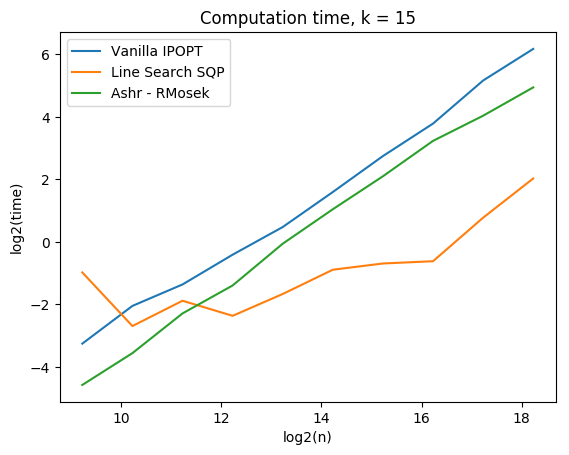

In [16]:
# setting : gridmult is fixed by m = 2
# n_max = 300 * 2^10 > 300000

iter = 10;
range = 300 * 2.^(1:iter);
m = 2;
t1 = zeros(iter); t2 = zeros(iter); t3 = zeros(iter);# t4 = zeros(iter);
d1 = zeros(iter); d2 = zeros(iter);# d3 = zeros(iter);
f1 = zeros(iter); f2 = zeros(iter);# f3 = zeros(iter);

# I don't know why this is needed, but error occurs otherwise
L = get_L(range[1],m)[1];
k = size(L,2);

# compute time
for i = 1:iter
    n = range[i];
    temp = get_L(n,m)
    L = temp[1];
    x3 = temp[2];
    t3[i] = temp[3]; # t3 : RMosek
    tic();
    x2 = ls_sqp(L);
    t2[i] = toq(); # t2 : Line search SQP
    tic();
    x1 = vanilla_ipopt(L); # t1 : Vanilla_IPOPT
    t1[i] = toq();
    f1[i] = eval_f(x2)/eval_f(x1) - 1;
    f2[i] = eval_f(x3)/eval_f(x1) - 1;
    d1[i] = norm(x2-x1,1);
    d2[i] = norm(x3-x1,1);
end

We plotted computation time in log scale.

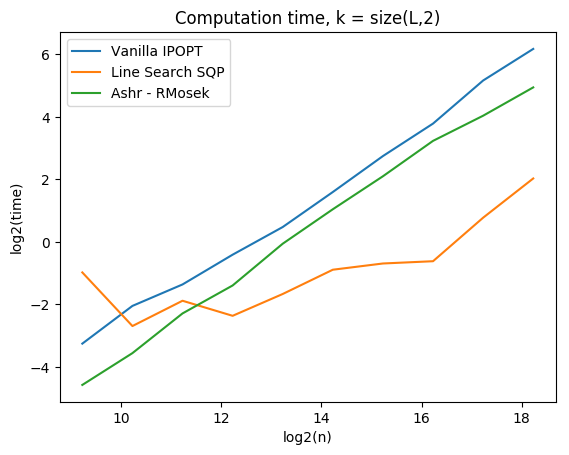

In [17]:
# make time plot
# scale = log2
fig, ax = subplots()
ax[:plot](log2(range),log2(t1),label="Vanilla IPOPT");
ax[:plot](log2(range),log2(t2),label="Line Search SQP");
ax[:plot](log2(range),log2(t3),label="Ashr - RMosek");
ax[:legend](loc="best")
xlabel("log2(n)");
ylabel("log2(time)");
title("Computation time, k = $size(L,2)");

Now we want to check if all are successfully converged.

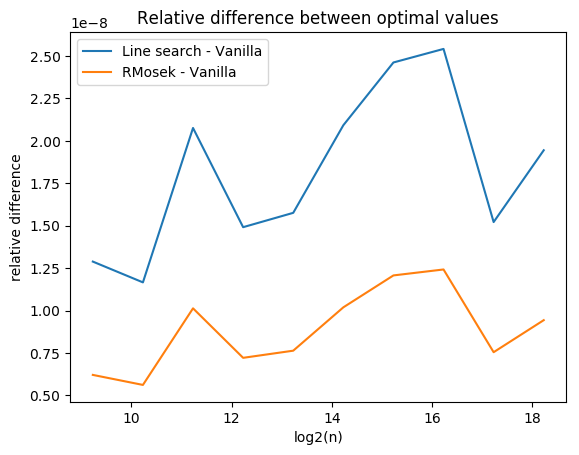

In [18]:
# make function value plot

fig, ax2 = subplots()
ax2[:plot](log2(range),f1,label="Line search - Vanilla");
ax2[:plot](log2(range),f2,label="RMosek - Vanilla");
ax2[:legend](loc="best")
xlabel("log2(n)");
ylabel("relative difference");
title("Relative difference between optimal values");

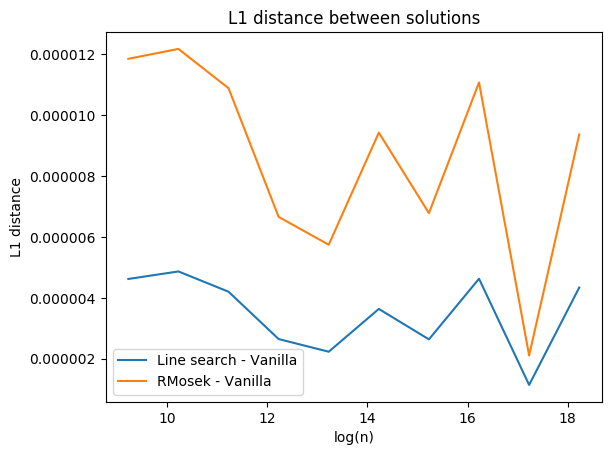

In [19]:
# make l1 distance plot

fig, ax3 = subplots()
ax3[:plot](log2(range),d1,label="Line search - Vanilla");
ax3[:plot](log2(range),d2,label="RMosek - Vanilla");
ax3[:legend](loc="best")
xlabel("log(n)");
ylabel("L1 distance");
title("L1 distance between solutions");

The next step is to fix $n$ and let $m$ decrease -- $k$ increase

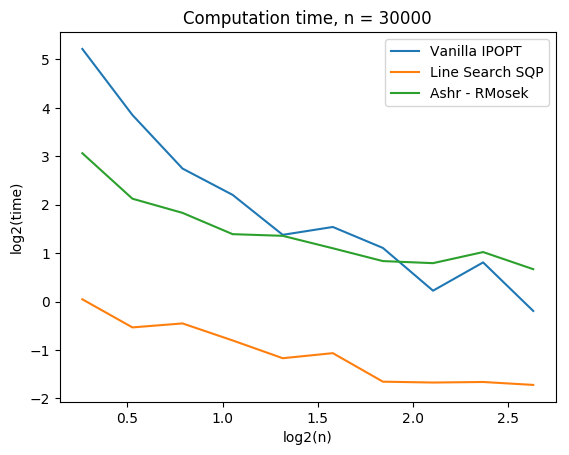

In [27]:
# setting : n is fixed by n = 30000

iter = 10;
range = 300 * 2.^(1:iter);
m = 1.2;
t1 = zeros(iter); t2 = zeros(iter); t3 = zeros(iter);# t4 = zeros(iter);
d1 = zeros(iter); d2 = zeros(iter);# d3 = zeros(iter);
f1 = zeros(iter); f2 = zeros(iter);# f3 = zeros(iter);

# compute time
for i = 1:iter
    n = range[i];
    temp = get_L(n,m)
    L = temp[1];
    
end

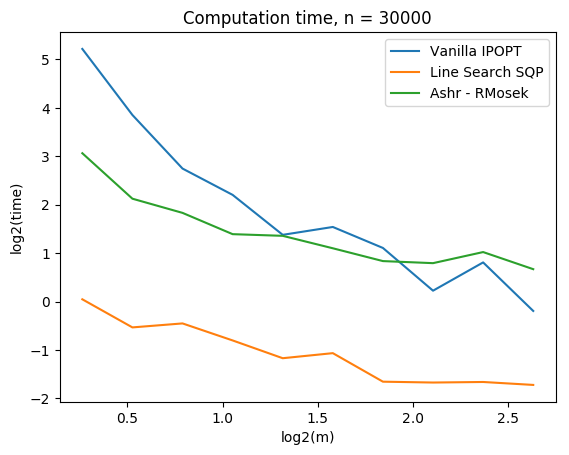

In [28]:
# make time plot
# scale = log2
fig, ax = subplots()
ax[:plot](log2(range),log2(t1),label="Vanilla IPOPT");
ax[:plot](log2(range),log2(t2),label="Line Search SQP");
ax[:plot](log2(range),log2(t3),label="Ashr - RMosek");
ax[:legend](loc="best")
xlabel("log2(m)");
ylabel("log2(time)");
title("Computation time, n = $n");

We will look at the time for gradient/Hessian computation and solving subproblem.

In [184]:
function ls_sqp_time(L)
    n = size(L,1); k = size(L,2);
    iter = 20;
    tol = 1e-2;
    x = ones(k)/k;
    t1 = []; t2 = [];
    for i = 1:iter
        # gradient and Hessian computation
        tic();
        Z = Diagonal(1./(L*x)) * L;
        g = -Z'*ones(n);
        H = Z'*Z;
        temp = toq();
        t1 = [t1;temp];
        
        # define a subproblem
        tic();
        m = Model(solver=IpoptSolver(print_level = 0));
        @variable(m, p[1:k]);
        @objective(m, Min, sum(0.5*p[i]*H[i,j]*p[j] for i = 1:k, j = 1:k )+sum(g[i]*p[i] for i = 1:k));
        @constraint(m, ec, sum(p[i] for i = 1:k) == 0); ## p is only in the simplex
        @constraint(m, ic, p+x .>= 0);                                    
        solve(m);
        temp = toq();
        t2 = [t2;temp];
                                        
        # convergence check - By KKT
        if norm(g - getdual(ic) - getdual(ec),Inf) < tol
            break;
        end
                                        
        # otherwise do update               
        x = abs(getvalue(p)+x); # make sure x is positive
        x = x/sum(x) # renormalize           
    end
    return mean(t1), mean(t2)
end

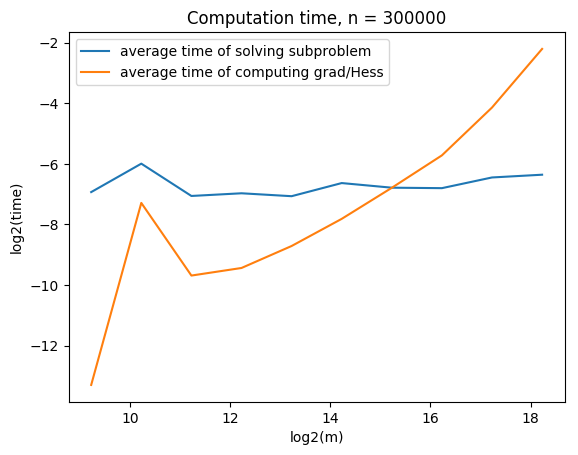

In [196]:
iter = 10;
range = 300 * 2.^(1:iter);
m = 2;
t1 = []; t2 = [];

for i = 1:iter
    L = get_L(range[i],m)[1];
    temp = ls_sqp_time(L);
    t1 = [t1;temp[1]];
    t2 = [t2;temp[2]];
end
t1 = convert(Array{Float64,1}, t1);
t2 = convert(Array{Float64,1}, t2);

# make time plot
# scale = log2
fig, ax = subplots()
ax[:plot](log2(range),log2(t2),label="average time of solving subproblem ");
ax[:plot](log2(range),log2(t1),label="average time of computing grad/Hess");
ax[:legend](loc="best")
xlabel("log2(m)");
ylabel("log2(time)");
title("Computation time, n = $n");

In [194]:
t2

10-element Array{Float64,1}:
 0.00034969
 0.0202479 
 0.00052632
 0.00199895
 0.00248923
 0.00463089
 0.00905375
 0.0189013 
 0.0564988 
 0.211635  

If $L$ is a low rank matrix, we want to solve approximate optimization function. Recall that (P) is
$$ \textrm{minimize}\quad f(x) = - \sum_{i=1}^n \log \sum_{j=1}^k x_j L_{ij} $$
$$ \textrm{subject to}\quad x \succeq 0,\quad \sum_{j=1}^m x_j = 1 $$.

Note that the objective function is
$$ f(x) = -\sum_{i=1}^n \log (Lx)_i $$.
Let $L = USV^T$ be a reduced SVD for numerically low rank matrix $L$. Then the problem becomes
$$ \textrm{minimize} f(x) = -\sum_{i=1}^n \log (USV^Tx)_i $$

In [ ]:
function rank_reduction(L)
    n = size(L,1); k = size(L,2);
    F = svdfact(L);
    iter = 20;
    tol = 1e-2;
    x = ones(k)/k;
    
    # svd for rank reduction
    F = svdfact(L);
    ind = F[:S] .> 1e-4;
    U = F[:U][:,ind];
    s = F[:S][ind];
    Vt = F[:Vt][ind,:];
    
    # iteration
    for i = 1:iter
        # gradient and Hessian computation -- Rank reduction method
        Z = Diagonal(1./(U*(Diagonal(s)*(Vt*x)))) * L;
        g = -Z'*ones(n);
        H = Z'*Z;
        
        # define a subproblem
        m = Model(solver=IpoptSolver(print_level = 0));
        @variable(m, p[1:k]);
        @objective(m, Min, sum(0.5*p[i]*H[i,j]*p[j] for i = 1:k, j = 1:k )+sum(g[i]*p[i] for i = 1:k));
        @constraint(m, ec, sum(p[i] for i = 1:k) == 0); ## p is only in the simplex
        @constraint(m, ic, p+x .>= 0);                                    
        solve(m);
                                        
        # convergence check - By KKT
        if norm(g - getdual(ic) - getdual(ec),Inf) < tol
            break;
        end
                                        
        # otherwise do update               
        x = abs(getvalue(p)+x); # make sure x is positive
        x = x/sum(x) # renormalize           
    end
    return x
end

In [145]:
L = get_L(300000,1.2)[1];

n = size(L,1); k = size(L,2);

In [146]:
F = svdfact(L);
    ind = F[:S] .> 1e-4;
    U = F[:U][:,ind];
    s = F[:S][ind];
    Vt = F[:Vt][ind,:];
x = ones(k)/k;

In [150]:
[@time Diagonal(1./(U*(Diagonal(s)*(Vt*x)))) * L;@time Diagonal(1./(L*x)) * L];

  0.215993 seconds (18 allocations: 116.731 MB, 75.05% gc time)
  0.054767 seconds (11 allocations: 116.730 MB, 1.54% gc time)


In [123]:
[@time 1./(U*(Diagonal(s)*(Vt*x)));@time 1./(L*x)];

  0.000942 seconds (15 allocations: 469.656 KB)
  0.001089 seconds (8 allocations: 469.063 KB)
